In [3]:
# import dependencies
import pandas as pd
import numpy as  np
from sqlalchemy import create_engine,inspect,func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from scipy import stats
import matplotlib.pyplot as plt

## Data Cleaning

In [4]:
# Read in both data tables to pandas
engine = create_engine("sqlite:///Data/hawaii.sqlite")
Base = automap_base()

contents = inspect(engine)
Base.prepare(engine,reflect = True)
Base.classes.keys()

['measurement', 'station']

In [50]:
#initialize sqlalchemy tools to query the sqlite database
Measurement = Base.classes.measurement
session = Session(engine)

In [5]:
# generate pandas datframes from the sqlite database
measurement_df = pd.read_sql("SELECT * FROM measurement",con = engine)
station_df = pd.read_sql("SELECT * FROM station",con = engine)

#Verify data import
display(measurement_df)
display(station_df)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [7]:
# Check data types and look for null values,
# null values observed for precipitation
display(measurement_df.dtypes)
print('')
display(measurement_df.count())

id           int64
station     object
date        object
prcp       float64
tobs       float64
dtype: object

id         19550
station    19550
date       19550
prcp       18103
tobs       19550
dtype: int64

In [153]:
#Find the most active station
mostactive = list(np.ravel(measurement_df.groupby('station')
                           .agg({'tobs':'count'})
                           .sort_values('tobs',ascending = False)
                           .reset_index().head(1)
                          ))

print(f'There are a total of {station_df["station"].count()} stations in the dataset')
print(f'The most active station is {mostactive[0]}')

There are a total of 9 stations in the dataset
The most active station is USC00519281


## Precipitation Analysis

In [36]:
def cumulative_rainfall(date):
    """Returns summary statistics and visualizes the last year of precipitation data
        Args:
            date (str): select the year ending in this date, format is '%Y-%m-%d' (YYYY-MM-DD)
       Return:
           Summary statistics on the data set, and a bar chart generated using pandas with matplotlib
    """
    def prcp_query(date):
        #Query the sqlite database using pandas, return one year of prcp data from all stations
        return (pd.read_sql("""
        SELECT date AS Date, prcp As Precipitation
        FROM measurement 
        WHERE Date > DATE(:date, '-1 years')
        ORDER BY Date ASC;
                               """,
        params = {'date':date}, con = engine)
                # drop null values and change the index
                .dropna().set_index("Date")
               )
                
    def prcp_plot(prcp_df):
        #plot the data using pandas and imporve the formating with matplotlib
        prcp_df.plot(figsize = (12,9),fontsize = 11)
        plt.title(f'Daily Precipitation Totals from Multiple Weather Stations in Hawaii',fontsize=18)
        plt.ylabel("Measured Precipitation (inches)", fontsize =14)
        plt.xlabel("Date", fontsize =14)
        plt.legend().remove()

    prcp_df = prcp_query(date)
    
    #return the visualization and summary statistics for the data
    return prcp_plot(prcp_df), display(prcp_df.describe())

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


(None, None)

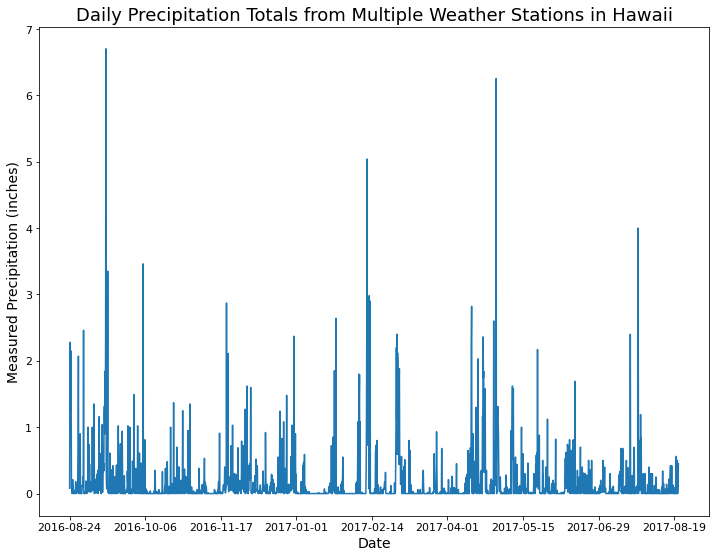

In [37]:
cumulative_rainfall('2017-08-23')

In [307]:
def annual_precip(date):
    """Determine the cumulative rainfall over the previous year for each station
        Args:
            date (str): returndata for one year prior to this date, format '%Y-%m-%d' ('YYYY-MM-DD')
        Return:
            pandas dataframe of cumulative rainfall totals for each station
    """
    # Query the sqlite database using pandas, join data from multiple tables
    return pd.read_sql("""
    SELECT m.station AS Station, SUM(m.prcp) As Total_Precipitation, s.latitude, s.longitude, s.elevation
    FROM measurement AS m 
    INNER JOIN station AS s ON m.station = s.station
    WHERE m.date > DATE(:date, '-1 years')
    GROUP BY m.station
    ORDER BY Total_Precipitation DESC;
                           """,params ={'date':date},con = engine).set_index('Station')

In [308]:
annual_precip('2017-08-23')

,Total_Precipitation,latitude,longitude,elevation
Station,,,,
USC00516128,147.11,21.33310,-157.80250,152.4
USC00519281,68.24,21.45167,-157.84889,32.9
USC00513117,48.36,21.42340,-157.80150,14.6
USC00519523,37.99,21.33556,-157.71139,19.5
USC00514830,33.19,21.52130,-157.83740,7.0
USC00519397,16.09,21.27160,-157.81680,3.0
USC00517948,4.59,21.39340,-157.97510,11.9


## Temperature Analysis

In [126]:
def temperature_distribution(date):
    """Visualize temperature data from the most active station in the dataset, for the last year
        Args:
            date (str): select the year ending in this date, format is '%Y-%m-%d' (YYYY-MM-DD)
        Return:
            Histogram of temperature measurements for the most active station in the data set
    """
    def most_active():
        #Query the sqlite data to determine the most active weather station
        #numpy ravel is used to convert the dataframe into a list
        station = list(np.ravel(pd.read_sql("""
        SELECT station
        FROM measurement
        GROUP BY station
        ORDER BY count(prcp) DESC
        LIMIT 1;
        """,con = engine)))
        
        return station[0]
    
    def select_data(date,station):
        
        return pd.read_sql("""
        SELECT tobs AS Temperature, station, date
        FROM  measurement
        WHERE Date > DATE(:date, '-1 years') AND station = :station""",
        params = {"station":station,"date":date}, con = engine)
    
    def plot_data(data):
        data.plot.hist(bins = 12, figsize = (12,9))
        plt.title(f'Daily Temperature Distribution for the Year Ending {date}',fontsize=18)
        plt.ylabel("Frequency", fontsize =14)
        plt.xlabel("Temperature (F)", fontsize =14)
        plt.legend().remove()
    
    station = most_active()
    data = select_data(date,station)
    
    return plot_data(data)

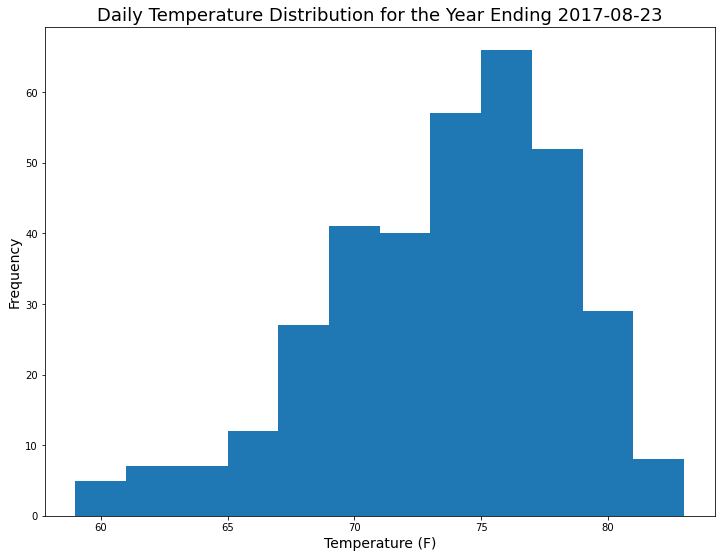

In [127]:
temperature_distribution('2017-08-23')

In [252]:
def monthly_comparison(month1,month2):
    """ Use a paired t-test to determine if there is a statistical differnce in observed temperature between two months
        Args:
            month1 (str): month in the format '%m' MM
            month2 (str): month in the format '%m' MM
        Returns:
            Interprion of the t-test results for a 95% confidence interval
            Calculated p-value
    """
    
    def query_month(month):
        #Query the sqlite database using pandas, return all data for the specified month
        month_data = pd.read_sql("""
        SELECT date, tobs, station
        FROM measurement
        WHERE strftime("%m",date) = :month
        """,params={'month':month},con = engine)
        
        # Add a cumulative count of each time a station appears. This will be used to form a primary key
        month_data['cc'] = month_data.groupby('station').cumcount()
        return month_data
    
    def compare(month1_data,month2_data):
        # Determine 'position' of each dataset for the merge, makes sure there are no null values created
        if len(month1_data) > len(month2_data):
            leftdata = month2_data
            rightdata = month1_data
        else:
            leftdata = month1_data
            rightdata = month2_data
        
        #merge the data to create equal length data sets for the t-test
        return pd.merge(leftdata,rightdata, on=['station','cc'],how = 'left').drop('cc',1)
    
    def interpret_ttest(temps_merge):
        #paired t-test using scipy.stats on the merged data
        results = stats.ttest_rel(temps_merge['tobs_x'],temps_merge['tobs_y'])
        
        # translate integer month into month name for output
        month_dict = {'01':'January','02':'February','03':'March','04':'April','05':'May','06':'June',
                     '07':'July','08':'August','09':'September','10':'October','11':'November','12':'December'}
        
        # Separate outputs for each interpretation of t-test results
        if results[1] < 0.05:
            return print(f'''
Using a 95% confidence interval,
there is a difference in mean temperatures for {month_dict[month1]} and {month_dict[month2]}
p-value: {results[1]}''')
        else:
            return print(f'''
Using a 95% confidence interval,
there is no difference in mean temperatures for {month_dict[month1]} and {month_dict[month2]}
p-value: {results[1]}''')
        
    month1_data = query_month(month1)
    month2_data = query_month(month2)
    temps_merge = compare(month1_data,month2_data)
    
    return interpret_ttest(temps_merge)

In [253]:
monthly_comparison('06','12')

Using a 95% confidence interval,
there is a difference in mean temperatures for June and December
p-value: 5.1149843653202015e-169


In [96]:
def avg_temp(start_date,end_date):
    
    # calc_temps was modified from starter code provided with the challenge
    def calc_temps(start_date,end_date):
        """Returns temperature statistics for a specified date range
        Args:
            start_date (string): A date string in the format ''%Y-%m-%d' 'YYYY-MM-DD'
            end_date (string): A date string in the format ''%Y-%m-%d' 'YYYY-MM-DD'
        Returns:
            TMIN, TAVG, and TMAX
        """
        return list(np.ravel((
            session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs))
            .filter(Measurement.date >= start_date)
            .filter(Measurement.date <= end_date)).all()
        ))

    def plot_temps(temp_stats):
        # Use matplotlib to generate a barplot with error bar for average temperature
        plt.figure(figsize = (12,9))
        plt.bar(1,temp_stats[1],yerr=((temp_stats[2]-temp_stats[0])/2))
        plt.title(f'Hawaii Average Temperature Between {start_date} and {end_date}',fontsize=18)
        plt.ylabel("Temperature (F)", fontsize =14)
        plt.xlim([0,2])
        plt.tick_params(axis = 'x',bottom=False,labelbottom=False)
        
    temp_stats = calc_temps(start_date,end_date)
    
    return plot_temps(temp_stats)

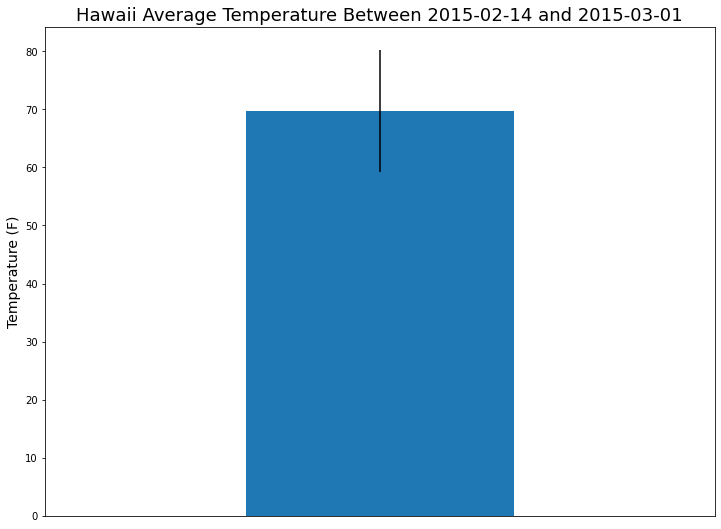

In [97]:
avg_temp('2015-02-14','2015-03-01')

In [124]:
def temp_normals(start_date, end_date):
    """Build a pandas dataframe of daily normals for the specified date range, and plot the results
        Args: 
            start_date (str): The start date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')
            end_date (str): The end date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')  
        Return: Visualization of the daily temperature normals
    """
    def date_list(start_date,end_date):
        #Query sqlite database using sqlalchemy
        return list(np.ravel(
            session.query(func.strftime('%m-%d',Measurement.date))
            .filter(func.strftime('%Y-%m-%d',Measurement.date) >= start_date)
            .filter(func.strftime('%Y-%m-%d',Measurement.date) <= end_date)
            .group_by(Measurement.date).all()
        ))
    
    # daily normals was modified from starter code provided with the challenge
    def daily_normals(date):
        #columns to return from the query
        temp_stats = [func.min(Measurement.tobs),
                      func.round(func.avg(Measurement.tobs),0), 
                      func.max(Measurement.tobs), 
                      func.strftime('%m-%d',Measurement.date)] 

        #Query sqlite database using sqlalchemy, return information for only the specified date
        return list(np.ravel(
            session.query(*temp_stats)
            .filter(func.strftime('%m-%d',Measurement.date) == date)
            .all()
        ))
    
    def build_df(normals):
        # Turn list of daily normals into a pandas df, give the columns appropriate headers,
        # and set 'Date' as the index
        return (pd.DataFrame(normals,columns = ['Minimum Temperature','Average Temperature',
                                                'Maximum Temperature','Date'])
                .astype({'Minimum Temperature': float,'Average Temperature': float,'Maximum Temperature': float})
                .set_index('Date'))
    
    def build_plot(normals_df):
        normals_df.plot.area(stacked = False, figsize = (12,9),fontsize = 12)
        plt.title(f'Historical Weather Data for Hawaii',fontsize=18)
        plt.ylabel("Temperature (F)", fontsize =14)
        plt.xlabel("Date", fontsize =14)
        plt.legend(prop={'size':14})

        
    specified_range = date_list(start_date,end_date)
    normals = [daily_normals(date) for date in specified_range]
    normals_df = build_df(normals)
    
    return build_plot(normals_df)

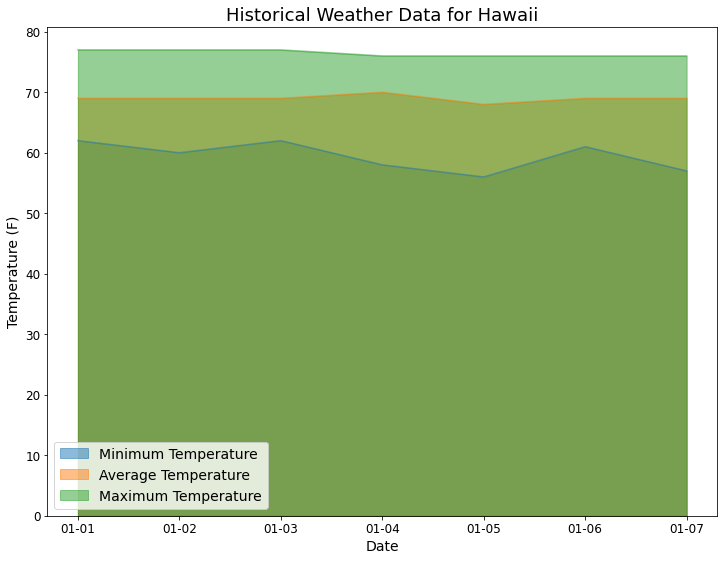

In [125]:
temp_normals('2017-01-01','2017-01-07')